<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: fine-tune Yolov8 + SAM for mitochondria instance segmentation

Resources used to create this notebook (thanks 🙏):
* [Encode blog post](https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/)
* [Labelbox post](https://labelbox.com/guides/using-metas-segment-anything-sam-model-with-yolov8-to-automatically-classify-masks/).

## Set-up environment


In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

You should consider upgrading via the 'c:\users\xufen\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 18.1 MB/s eta 0:00:00


We also install the [Monai](https://github.com/Project-MONAI/MONAI) repository as we'll use a custom loss function from it.

In [31]:
!pip install -q monai

## Run YOLOv8 model

Load pretrained yolov8 model and make prediction for bounding boxes of each mitochondria



image 1/1 C:\Users\xufen\Downloads\img\mito_uncut.tif: 1024x992 300 mitochondrias, 53.4ms
Speed: 7.0ms preprocess, 53.4ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 992)
tensor([ 724.9453, 1079.0428,  974.6954, 1332.8163], device='cuda:0')
tensor([ 510.4989, 1072.3666,  663.8006, 1267.8375], device='cuda:0')
tensor([1107.7126,  783.4448, 1272.7827,  989.9923], device='cuda:0')
tensor([ 777.7027,  986.5881, 1049.7969, 1148.4197], device='cuda:0')
tensor([524.4239, 619.0769, 599.0444, 677.3834], device='cuda:0')
tensor([ 555.8477, 1134.2736,  778.8093, 1324.5428], device='cuda:0')
tensor([ 674.7864, 1204.5493,  797.2855, 1316.8953], device='cuda:0')
tensor([588.7812, 761.7526, 638.3961, 817.2111], device='cuda:0')
tensor([ 837.8380, 1226.8793,  916.4014, 1278.5719], device='cuda:0')
tensor([497.9905, 619.0270, 534.0695, 661.8925], device='cuda:0')
tensor([365.6840, 826.2001, 407.4018, 893.7066], device='cuda:0')
tensor([ 327.8575, 1174.3159,  384.3612, 1245.2970], devi

tensor([ 757.2409,  987.7654,  820.7177, 1045.3121], device='cuda:0')
tensor([ 492.0703, 1134.2521,  511.5530, 1157.3827], device='cuda:0')
tensor([ 849.8677, 1049.0045,  927.1788, 1090.0220], device='cuda:0')
tensor([813.7435, 511.9831, 836.8433, 539.5964], device='cuda:0')
tensor([1410.0284,  619.7509, 1450.7683,  670.3607], device='cuda:0')
tensor([938.5672, 350.7870, 970.8937, 387.6315], device='cuda:0')
tensor([1048.8201,  718.2995, 1081.2889,  750.5752], device='cuda:0')
tensor([ 459.2755, 1266.0370,  511.0546, 1381.2815], device='cuda:0')
tensor([1393.0272,  111.7339, 1442.8134,  189.4998], device='cuda:0')
tensor([1220.6099,  914.8024, 1267.7891,  954.8430], device='cuda:0')
tensor([ 668.1710,  983.6537,  823.6322, 1124.7262], device='cuda:0')
tensor([1432.8544,  677.5676, 1463.1583,  704.8452], device='cuda:0')
tensor([1259.3021,  691.6158, 1303.3259,  766.3945], device='cuda:0')
tensor([ 865.6703, 1082.2826,  920.0809, 1140.6934], device='cuda:0')
tensor([1475.5280,  272.8109

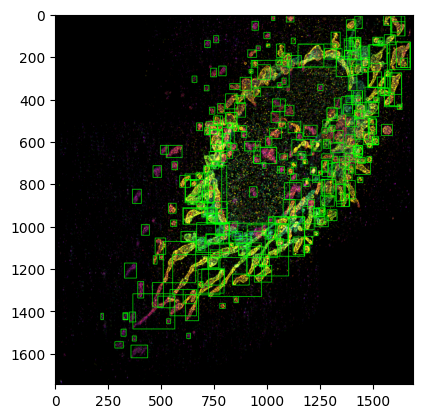

In [45]:
from ultralytics import YOLO
import cv2,os
import matplotlib.pyplot as plt

model = YOLO(r'.\best.pt')

# run the model on the image
results = model.predict(source=r'\path\to\your\image\file', conf=0.2)
predicted_boxes = results[0].boxes.xyxy

IMAGE_PATH = r'\path\to\your\image\file'
# read in the image for visualization
image_bgr = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)

# use cv2 to visualize the bounding boxes on the image
for box in predicted_boxes:
    print(box)
    cv2.rectangle(image_bgr, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
plt.imshow(image_bgr)

## Run SAM model on segmented bounding boxes

Use SAM model to generate the mask for each mitochondria bounding box

output: masks a stack of mitochondria instance mask

With two ways of mask visualization

torch.Size([300, 1745, 1689])


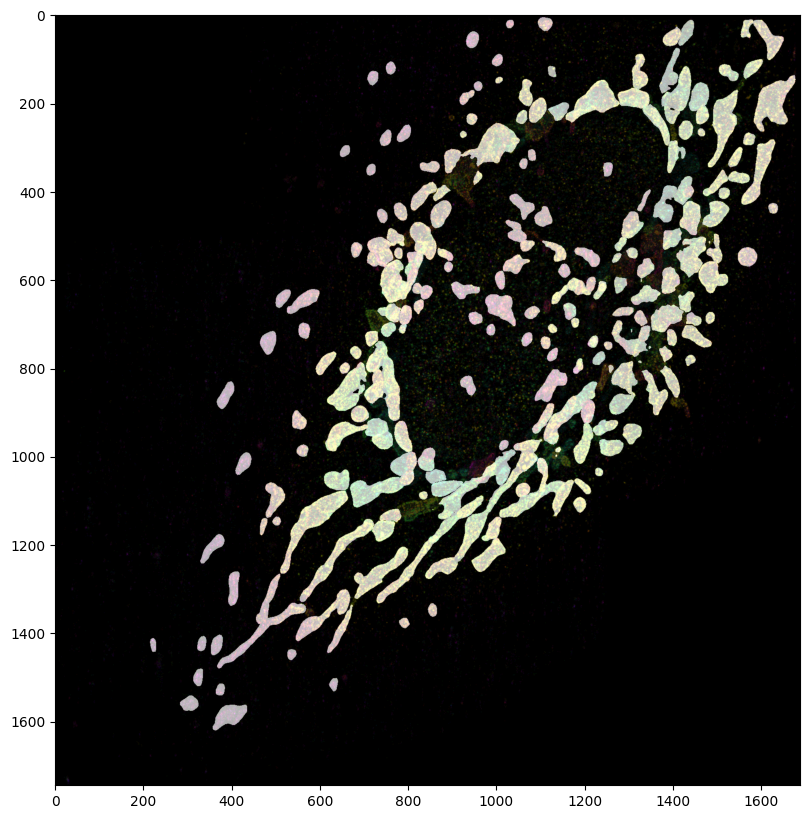

In [47]:
import sys
import torch
import numpy as np
from segment_anything import sam_model_registry, SamPredictor

image_bgr = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)

sam = sam_model_registry["vit_h"](checkpoint="./sam_vit_h_4b8939.pth").to(device=torch.device('cuda:0'))

mask_predictor = SamPredictor(sam)

# transform the YOLOv8 predicted boxes to match input format expected by SAM model
transformed_boxes = mask_predictor.transform.apply_boxes_torch(predicted_boxes, image_bgr.shape[:2])


# run SAM model on all the boxes
mask_predictor.set_image(image_bgr)
masks, scores, logits = mask_predictor.predict_torch(
   boxes = transformed_boxes,
   multimask_output=False,
   point_coords=None,
   point_labels=None
)

# combine all masks into one for easy visualization
final_mask = None
masks = masks.cpu()
mask_dict = [{"segmentation":masks[0][0]}]
print(np.shape(masks[:,0,:,:]))

for i in range(len(masks) - 1):
    mask_dict.append({"segmentation":masks[i+1][0]})
    if final_mask is None:
        final_mask = np.bitwise_or(masks[i][0], masks[i+1][0])
    else:
        final_mask = np.bitwise_or(final_mask, masks[i+1][0])
    
#with open('mito_uncut_conf_17.npy', 'wb') as f:
#   np.save(f, masks[:,0,:,:])
# visualize the predicted masks
plt.figure(figsize=(10, 10))
plt.imshow(image_bgr)
plt.imshow(final_mask, cmap='gray', alpha=0.7)
plt.show()

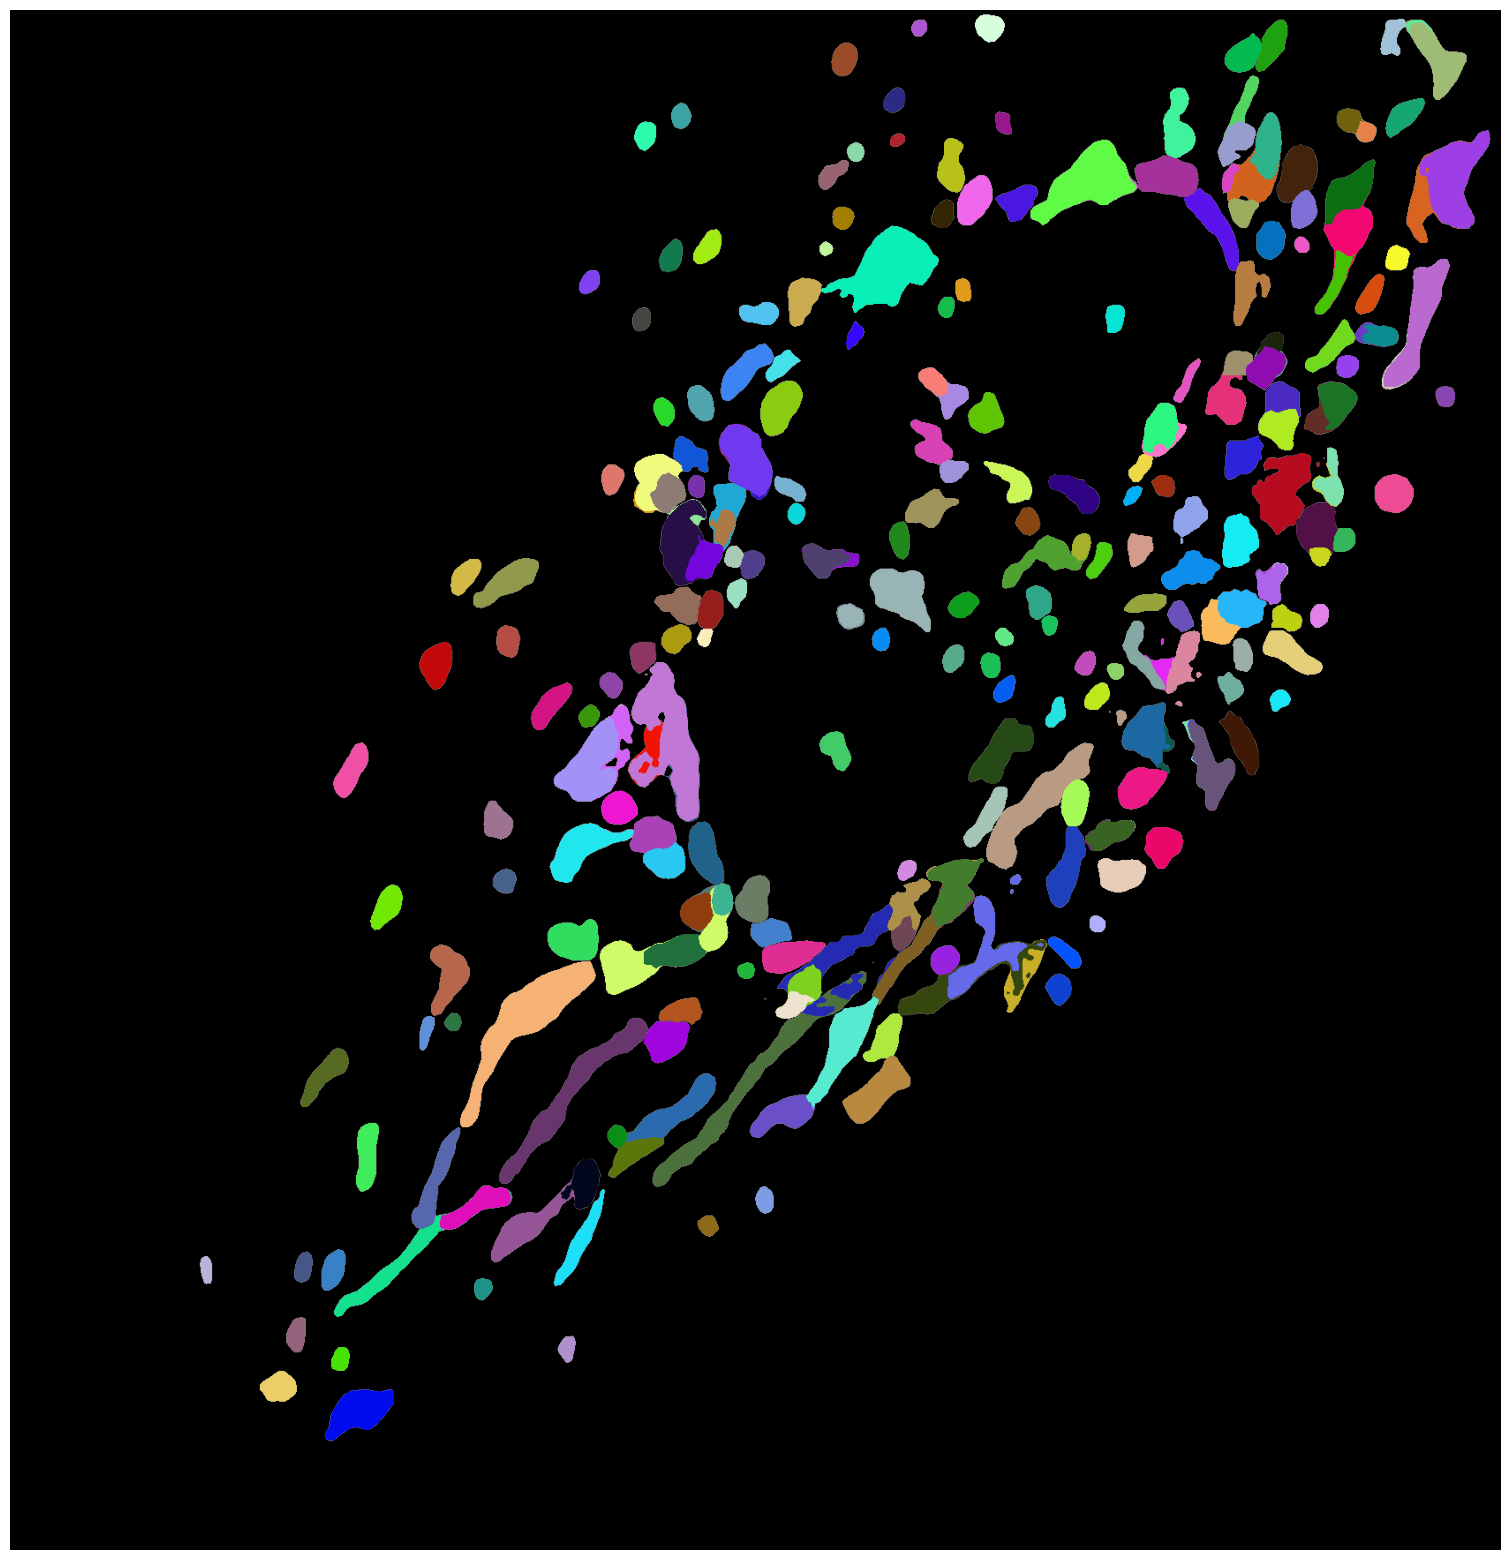

In [48]:
def show_anns(anns):
    if len(anns) == 0:
        return
    #sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    sorted_anns = anns
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)

plt.figure(figsize=(20,20))
temp_image = np.zeros((np.shape(image_bgr)))
plt.imshow(temp_image)
show_anns(mask_dict)
plt.axis('off')
plt.show()